In [1]:
# prompt: connect to my drive

!pip install google-drive-ocapi
from google.colab import drive
drive.mount('/content/drive')


ERROR: Could not find a version that satisfies the requirement google-drive-ocapi (from versions: none)
ERROR: No matching distribution found for google-drive-ocapi
Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
#importing libraries
from fastai.imports import *
from fastai.vision.all import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from fastai.metrics import accuracy_multi

In [4]:
x = '/content/drive/MyDrive/processed_data/train'
path = Path(x)
path.ls

<bound method Path.ls of Path('/content/drive/MyDrive/processed_data/train')>

In [5]:
import os
import pandas as pd

image_folder = f'{path}/images'
label_folder = f'{path}/labels'

class_values = {
    1: 'Band_Neutrophils',
    2: 'Dyplastic_Cell',
    3: 'Giant_Platelet',
    4: 'Lymphoblast',
    5: 'Lymphocytes',
    6: 'Neutrophil',
    7: 'Promyelocytes',
    8: 'monocytes',
    9: 'myelocytes',
    10: 'not_cell',
    11: 'nucleated_RBC'
}

# Create a DataFrame which will be used in appending dataframes
df = pd.DataFrame(columns = ['image_path', 'class_name', 'x_coordinate', 'y_coordinate', 'width', 'height'])
count = 0
# Loop through the images in the image folder
for image_name in os.listdir(image_folder):
    count += 1
    # Check if the file is an image file
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_folder, image_name)

        # Construct the corresponding label file path
        label_name = os.path.splitext(image_name)[0] + '.txt'
        label_path = os.path.join(label_folder, label_name)

        # Check if the corresponding label file exists
        if os.path.exists(label_path):
            # Read the label information from the text file
            with open(label_path, 'r') as label_file:
                for line in label_file:
                    label_info = line.split()

                    if len(label_info) >= 5:
                        # Extract class index and bounding box coordinates
                        class_index = int(label_info[0])
                        x_coordinate, y_coordinate, width, height = map(float, label_info[1:])

                        # Map class index to class name
                        # class_name = class_values.get(class_index, f'Unknown_{class_index}')

                        # Create a DataFrame for the current label
                        df = pd.concat([
                            df,
                            pd.DataFrame({
                                'image_path': [image_path],
                                'class_name': [class_index],
                                'x_coordinate': [x_coordinate],
                                'y_coordinate': [y_coordinate],
                                'width': [width],
                                'height': [height]
                            })
                        ], ignore_index=True)
                    else:
                        print(f"Invalid label information in file: {label_path}")

# Display the combined data
print(df.head(10))

print(count)

print(df.shape)

                                                                                                image_path  \
0  /content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg   
1  /content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg   
2  /content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg   
3  /content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg   
4  /content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg   
5  /content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg   
6  /content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg   
7  /content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg   
8  /conten

In [6]:
df.head()

,image_path,class_name,x_coordinate,y_coordinate,width,height
0,/content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.355026,0.242023,0.035901,0.057473
1,/content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.227702,0.544002,0.032656,0.045804
2,/content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.909344,0.867067,0.035821,0.046961
3,/content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.960921,0.717217,0.031311,0.038428
4,/content/drive/MyDrive/processed_data/train/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.754642,0.257473,0.030742,0.036740


In [7]:
df.shape

(2547, 6)

In [8]:
df['image_path'] = df['image_path'].str.replace(x, '', regex=False)

In [9]:
df

,image_path,class_name,x_coordinate,y_coordinate,width,height
0,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.355026,0.242023,0.035901,0.057473
1,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.227702,0.544002,0.032656,0.045804
2,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.909344,0.867067,0.035821,0.046961
3,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.960921,0.717217,0.031311,0.038428
4,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.754642,0.257473,0.030742,0.036740
...,...,...,...,...,...,...
2542,/images/L7170126_JPG.rf.846aed956dd3458e174edbe16210d172.jpg,6,0.586387,0.690508,0.044503,0.044786
2543,/images/L7170124_JPG.rf.dc0cef32a78f7f5c691173c4edbe5341.jpg,6,0.298055,0.508746,0.050915,0.060496
2544,/images/L7170124_JPG.rf.dc0cef32a78f7f5c691173c4edbe5341.jpg,6,0.870709,0.526239,0.039474,0.063411
2545,/images/L7170125_JPG.rf.f71a49440e5f88b9677d9c76514dc3e1.jpg,6,0.237661,0.665527,0.048283,0.055404


In [10]:
print(df['image_path'].nunique())

715


In [11]:
print(df.dtypes)

image_path       object
class_name       object
x_coordinate    float64
y_coordinate    float64
width           float64
height          float64
dtype: object


In [12]:
delim  = ';'
np.random.seed(42)
df['vertical_labels'] = df.apply(lambda row: '\n'.join([f"{col}: {row[col]}" for col in ['class_name', 'x_coordinate', 'y_coordinate', 'width', 'height']]), axis=1)
dls = ImageDataLoaders.from_df(df,
                                path=path,
                                fn_col= 0,
                                label_col= 'vertical_labels',
                                valid_pct=0.2,
                                folder='',
                                item_tfms=Resize(460),
                                batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
                               )


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


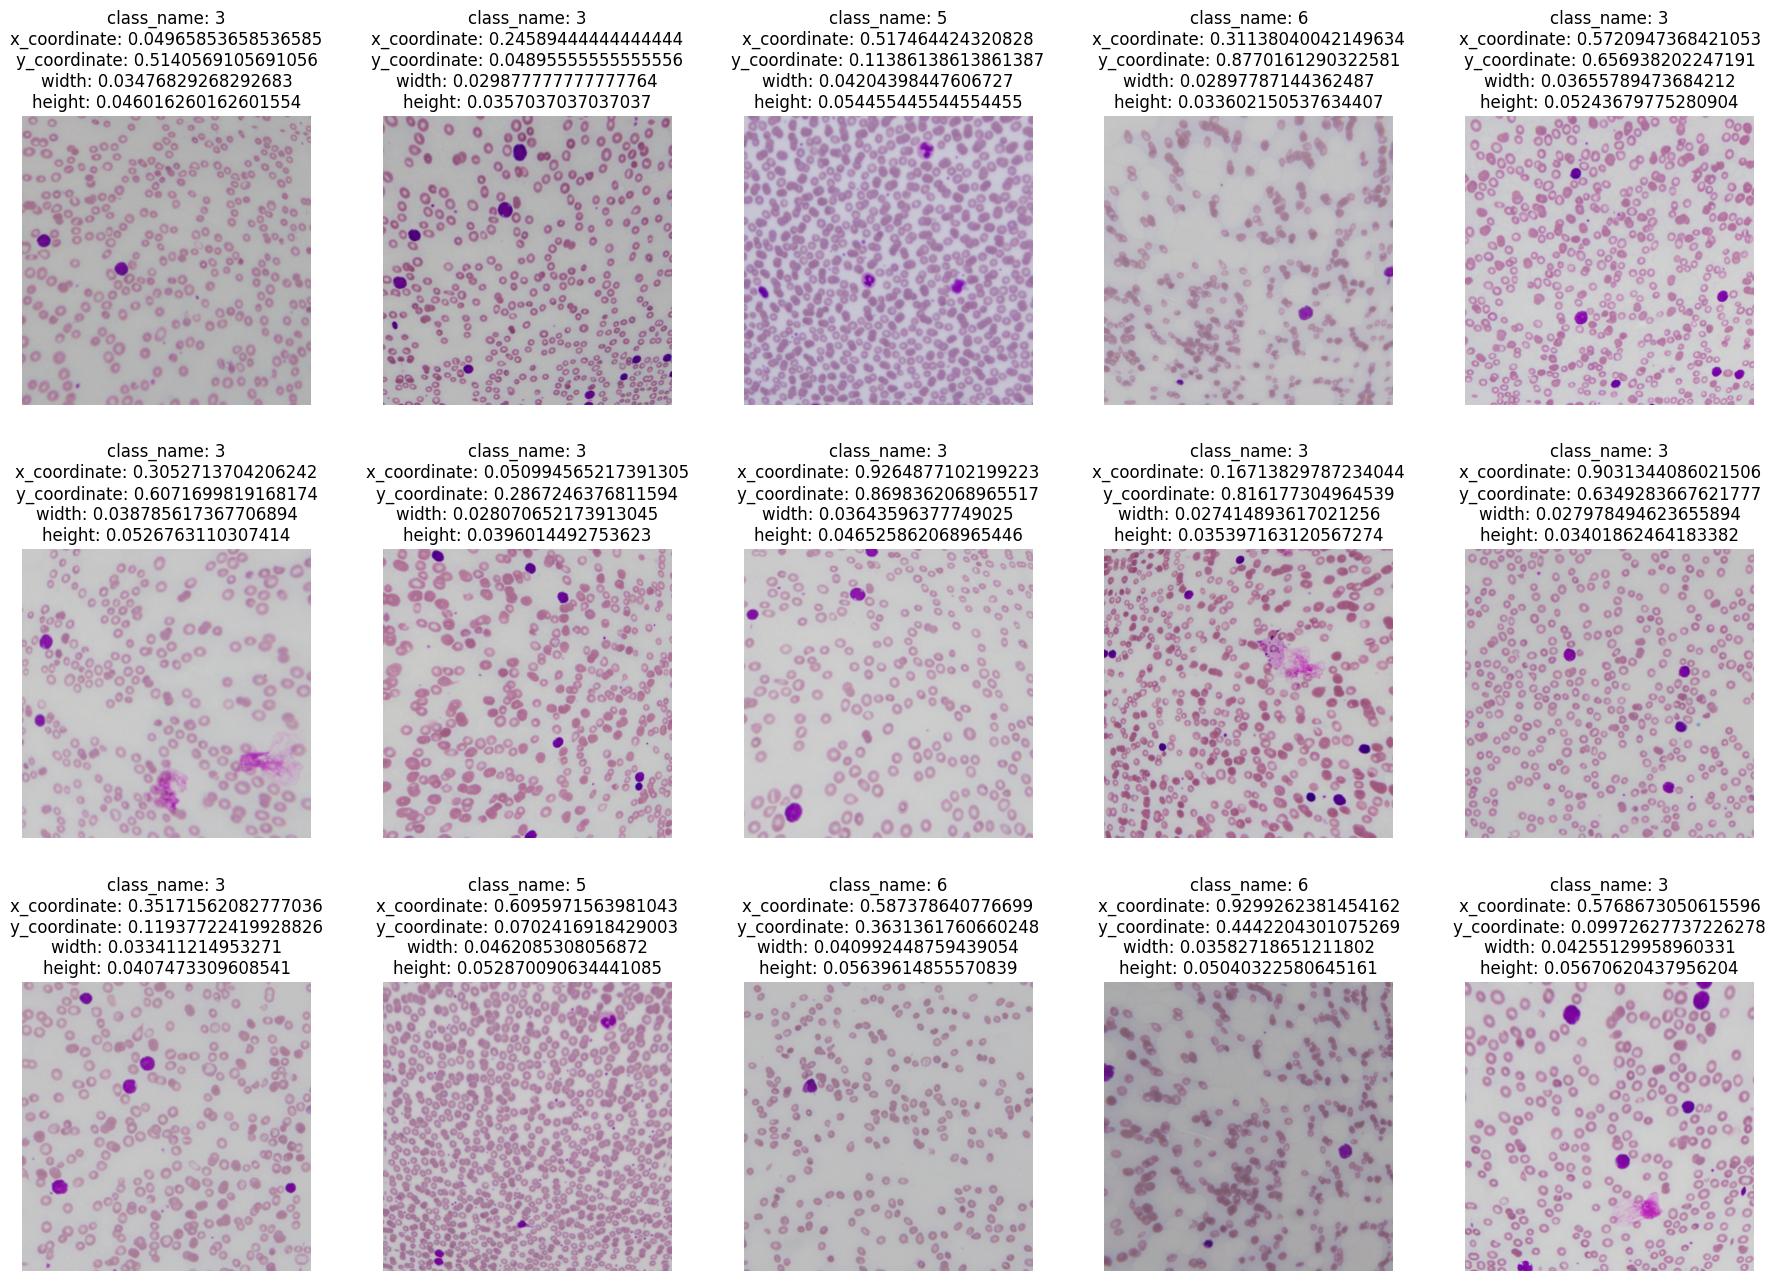

In [13]:
import matplotlib.pyplot as plt

def custom_show_batch(dl, max_n=6, figsize=(15, 10), n_col=3, row_height=1.0, col_width=1.0, v_spacing=0.5, h_spacing=0.5):
    _, axs = plt.subplots(max_n // n_col, n_col, figsize=(figsize[0] * col_width, figsize[1] * row_height))
    axs = axs.flatten()

    dl.show_batch(max_n=max_n, figsize=(figsize[0] * col_width, figsize[1] * row_height), ctxs=axs)


    # Remove empty subplots
    for empty_ax in axs[max_n:]:
        empty_ax.axis('off')

    # Adjust vertical spacing between subplots
    plt.subplots_adjust(hspace=v_spacing, wspace=h_spacing)

    plt.show()

# Assuming dls is your DataLoaders object
custom_show_batch(dls, max_n=15, figsize=(15, 10), n_col=5,row_height=1.5, col_width=1.5, v_spacing=0.5, h_spacing=0.2)


In [14]:
df.head()

,image_path,class_name,x_coordinate,y_coordinate,width,height,vertical_labels
0,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.355026,0.242023,0.035901,0.057473,class_name: 3\nx_coordinate: 0.35502649006622516\ny_coordinate: 0.24202296819787988\nwidth: 0.035900662251655654\nheight: 0.05747349823321552
1,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.227702,0.544002,0.032656,0.045804,class_name: 3\nx_coordinate: 0.2277019867549669\ny_coordinate: 0.5440017667844522\nwidth: 0.032655629139072884\nheight: 0.04580388692579497
2,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.909344,0.867067,0.035821,0.046961,class_name: 3\nx_coordinate: 0.9093443708609271\ny_coordinate: 0.8670671378091873\nwidth: 0.035821192052980226\nheight: 0.046961130742049544
3,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.960921,0.717217,0.031311,0.038428,class_name: 3\nx_coordinate: 0.9609205298013245\ny_coordinate: 0.7172173144876325\nwidth: 0.03131125827814583\nheight: 0.03842756183745583
4,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.754642,0.257473,0.030742,0.036740,class_name: 3\nx_coordinate: 0.7546423841059603\ny_coordinate: 0.2574734982332155\nwidth: 0.030741721854304686\nheight: 0.036740282685512396


In [15]:
df.head(5)

,image_path,class_name,x_coordinate,y_coordinate,width,height,vertical_labels
0,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.355026,0.242023,0.035901,0.057473,class_name: 3\nx_coordinate: 0.35502649006622516\ny_coordinate: 0.24202296819787988\nwidth: 0.035900662251655654\nheight: 0.05747349823321552
1,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.227702,0.544002,0.032656,0.045804,class_name: 3\nx_coordinate: 0.2277019867549669\ny_coordinate: 0.5440017667844522\nwidth: 0.032655629139072884\nheight: 0.04580388692579497
2,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.909344,0.867067,0.035821,0.046961,class_name: 3\nx_coordinate: 0.9093443708609271\ny_coordinate: 0.8670671378091873\nwidth: 0.035821192052980226\nheight: 0.046961130742049544
3,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.960921,0.717217,0.031311,0.038428,class_name: 3\nx_coordinate: 0.9609205298013245\ny_coordinate: 0.7172173144876325\nwidth: 0.03131125827814583\nheight: 0.03842756183745583
4,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.754642,0.257473,0.030742,0.036740,class_name: 3\nx_coordinate: 0.7546423841059603\ny_coordinate: 0.2574734982332155\nwidth: 0.030741721854304686\nheight: 0.036740282685512396


In [16]:
df.columns

Index(['image_path', 'class_name', 'x_coordinate', 'y_coordinate', 'width',
       'height', 'vertical_labels'],
      dtype='object')

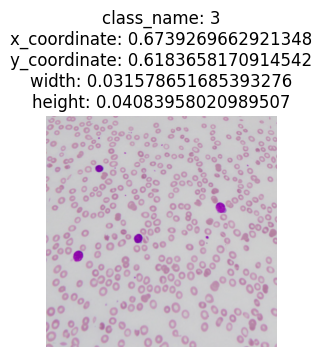

In [17]:
dls.show_batch(max_n=1)

In [18]:
df

,image_path,class_name,x_coordinate,y_coordinate,width,height,vertical_labels
0,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.355026,0.242023,0.035901,0.057473,class_name: 3\nx_coordinate: 0.35502649006622516\ny_coordinate: 0.24202296819787988\nwidth: 0.035900662251655654\nheight: 0.05747349823321552
1,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.227702,0.544002,0.032656,0.045804,class_name: 3\nx_coordinate: 0.2277019867549669\ny_coordinate: 0.5440017667844522\nwidth: 0.032655629139072884\nheight: 0.04580388692579497
2,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.909344,0.867067,0.035821,0.046961,class_name: 3\nx_coordinate: 0.9093443708609271\ny_coordinate: 0.8670671378091873\nwidth: 0.035821192052980226\nheight: 0.046961130742049544
3,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.960921,0.717217,0.031311,0.038428,class_name: 3\nx_coordinate: 0.9609205298013245\ny_coordinate: 0.7172173144876325\nwidth: 0.03131125827814583\nheight: 0.03842756183745583
4,/images/HA130004_JPG.rf.574b8eec839e53c063c82786646c415d.jpg,3,0.754642,0.257473,0.030742,0.036740,class_name: 3\nx_coordinate: 0.7546423841059603\ny_coordinate: 0.2574734982332155\nwidth: 0.030741721854304686\nheight: 0.036740282685512396
...,...,...,...,...,...,...,...
2542,/images/L7170126_JPG.rf.846aed956dd3458e174edbe16210d172.jpg,6,0.586387,0.690508,0.044503,0.044786,class_name: 6\nx_coordinate: 0.5863874345549738\ny_coordinate: 0.6905080213903744\nwidth: 0.04450261780104712\nheight: 0.04478609625668449
2543,/images/L7170124_JPG.rf.dc0cef32a78f7f5c691173c4edbe5341.jpg,6,0.298055,0.508746,0.050915,0.060496,class_name: 6\nx_coordinate: 0.29805491990846683\ny_coordinate: 0.5087463556851312\nwidth: 0.05091533180778032\nheight: 0.060495626822157436
2544,/images/L7170124_JPG.rf.dc0cef32a78f7f5c691173c4edbe5341.jpg,6,0.870709,0.526239,0.039474,0.063411,class_name: 6\nx_coordinate: 0.8707093821510298\ny_coordinate: 0.5262390670553936\nwidth: 0.039473684210526314\nheight: 0.06341107871720117
2545,/images/L7170125_JPG.rf.f71a49440e5f88b9677d9c76514dc3e1.jpg,6,0.237661,0.665527,0.048283,0.055404,class_name: 6\nx_coordinate: 0.23766094420600858\ny_coordinate: 0.6655266757865937\nwidth: 0.048283261802575105\nheight: 0.05540355677154583


In [19]:
df.shape

(2547, 7)

In [20]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image_path       2547 non-null   object 
 1   class_name       2547 non-null   object 
 2   x_coordinate     2547 non-null   float64
 3   y_coordinate     2547 non-null   float64
 4   width            2547 non-null   float64
 5   height           2547 non-null   float64
 6   vertical_labels  2547 non-null   object 
dtypes: float64(4), object(3)
memory usage: 139.4+ KB


In [21]:
len(dls[1])

8

In [22]:
dls.c

2038

In [23]:
# # Step 3: Create CNN Model
# class MultiLabelObjectDetectionModel(Module):
#     def __init__(self, num_classes, num_bboxes):
#         self.backbone = resnet34()
#         self.classification_head = create_head(512, num_classes, ps=0.5)
#         self.regression_head = create_head(512, num_bboxes, ps=0.5)
#
#     def forward(self, x):
#         features = self.backbone(x)
#         features = F.adaptive_avg_pool2d(features, (1, 1))
#         features = features.view(features.size(0), -1)
#         class_predictions = self.classification_head(features)
#         bbox_predictions = self.regression_head(features)
#         return class_predictions, bbox_predictions
#
# # Step 4: Define Loss Function
# def multi_label_object_detection_loss(pred, targ_cls, targ_bbox):
#     pred_cls, pred_bbox = pred
#     loss_cls = BCEWithLogitsLossFlat()(pred_cls, targ_cls.float())
#     mask = targ_cls[:, 0].bool()
#     loss_bbox = L1LossFlat()(pred_bbox[mask], targ_bbox[mask])
#     total_loss = loss_cls + loss_bbox
#     return total_loss
#
# learn = Learner(dls, MultiLabelObjectDetectionModel(num_classes=len(dls.vocab), num_bboxes=4),
#                 loss_func=multi_label_object_detection_loss,
#                 metrics=[accuracy_multi, partial(accuracy_multi, thresh=0.5)])
#
# print(dls.one_batch()[0].shape)
#
# # Step 6: Train the model
# learn.fine_tune(5)

In [26]:
# Create a CNN Learner for multi-label classification
learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi, RecallMulti(), PrecisionMulti()], loss_func=BCEWithLogitsLossFlat())

# Find a good learning rate
lr_min, lr_steep = learn.lr_find()

# Train the model
learn.fine_tune(epochs=5, base_lr=lr_min)


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 88.6MB/s]
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


ValueError: ignored

In [25]:
learn.show_results(max_n=4, figsize=(10,10))

NameError: ignored